Import necessary modules

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np
import datetime

# Data Quality Assessment
from collections import Counter
import pandas_profiling
import missingno as msno

# Plot Tools
from matplotlib import pyplot as plt
import seaborn as sns

# Prediction Tools
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score, confusion_matrix

# Part 1 - Exploratory Data Analysis

Quick data quality assessment

In [2]:
# Read dataset
df = pd.read_json('logins.json')

In [3]:
# Check datatype
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB
None


In [4]:
# Check head of dataset
display(df.head())

login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21

In [5]:
# Check tail of dataset
display(df.tail())

login_time
93137 1970-04-13 18:50:19
93138 1970-04-13 18:43:56
93139 1970-04-13 18:54:02
93140 1970-04-13 18:57:38
93141 1970-04-13 18:54:23

In [6]:
# Check if NaN exists
print(df.isna().any())

login_time    False
dtype: bool


In [7]:
# Check how far time distance is
print(df['login_time'][len(df)-1] - df['login_time'][0])
# days hours:minutes:seconds

101 days 22:41:05


In [8]:
# Check if duplication exists
pot_dup = {}
for k, v in Counter(df['login_time']).items():
    if v > 1:
        pot_dup[k] = [v]
pot_dup = pd.DataFrame(pot_dup).T.reset_index().rename(columns={
    'index':'timestamp', 0:'potential duplications'})

In [9]:
# Potential duplications might be existed
display(pot_dup)

timestamp  potential duplications
0   1970-01-02 10:59:52                       2
1   1970-01-02 12:27:48                       2
2   1970-01-02 15:08:27                       2
3   1970-01-02 16:14:36                       2
4   1970-01-02 22:03:36                       2
..                  ...                     ...
863 1970-04-12 05:24:21                       2
864 1970-04-12 15:46:43                       2
865 1970-04-12 17:12:21                       2
866 1970-04-13 12:23:46                       2
867 1970-04-13 13:44:18                       2

[868 rows x 2 columns]

Aggregate login counts within 15 minute time interval each

In [10]:
# Create total seconds column
thelist = []
begin = min(df['login_time'])
for i in range(len(df)):
    result = df['login_time'][i] - begin
    thelist.append(result.total_seconds())
df = pd.concat([df,pd.DataFrame(thelist)],axis=1).rename(columns = {0:'total_seconds'})

In [11]:
df = df.sort_values(by='total_seconds')

In [12]:
thelist = []
base = 0
ID = 0
for i in range(len(df)):
    if df.iloc[i,1] - base < 15*60:
        thelist.append(ID)
    else:
        base = df.iloc[i,1]
        ID=ID+1
        thelist.append(ID)
df['15min_id'] = thelist

In [13]:
df = df.merge(pd.DataFrame(df.groupby('15min_id').count()['login_time']).reset_index().rename(
    columns = {'login_time':'15min_logins'}),on='15min_id',how='inner')

In [14]:
thelist = []
base = 0
ID = 0
for i in range(len(df)):
    if df.iloc[i,1] - base < 24*60*60:
        thelist.append(ID)
    else:
        base = df.iloc[i,1]
        ID=ID+1
        thelist.append(ID)
df['24hours_id'] = thelist

In [15]:
df = df.merge(pd.DataFrame(df.groupby('24hours_id').mean()['15min_logins']).reset_index().rename(
    columns = {'15min_logins':'average_per_24hrs'}),on='24hours_id',how='inner') 

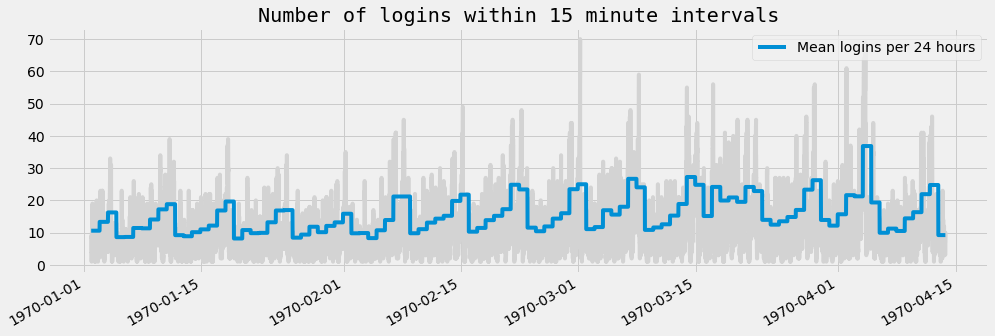

In [16]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df['login_time'], df['15min_logins'],color='lightgrey')
ax.plot(df['login_time'], df['average_per_24hrs'],
        label='Mean logins per 24 hours', drawstyle='default')
ax.set_title('Number of logins within 15 minute intervals',family = 'monospace')
fig.autofmt_xdate(rotation=30)
ax.legend(loc='upper right')
plt.show()

As indicated by the quick time series analysis, the login behavior is likely to be weekly seasonality. The highest number of login within 15 minute interval is 70 while the lowest number is 1. However, the lowest average number of login within 15 minute interval for each 24 hours is about 8.

# Part 2 - Experiment and Metrics Design

<p style="text-align: justify">
<b>1.) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?</b></p>

<p style="text-align: justify">
The objective of this experiment is to encourage drivers partners to serve both cities. The number of trips a day associated with bus ID plus geographic area and date is a critical piece of information for this experiment. The metric is that serving both cities associated with bus ID is not occurred or occurred (0 and 1) given a day called `serving_both`. The binary metric can be thought of as failure and success.</p>
    
<p style="text-align: justify">
<b> 2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on: </b></p>

<b> a) how you will implement the experiment </b>
    
<p style="text-align: justify">
The statistical inference about two populations using binomial distribution is in use to test hypothesis collected by Randomized Controlled Trial approach. Let <i>p<sub>1</sub></i> and <i>p<sub>2</sub></i> be proportion of `serving_both` with and without reimbursement.</p>
    
<p style='text-align: center'>
<b>H<sub>0</sub>:</b> <i>p<sub>1</sub></i> - <i>p<sub>2</sub></i> $\leq$ 0 </p>

<p style='text-align: center'>
<b>H<sub>a</sub>:</b> <i>p<sub>1</sub></i> - <i>p<sub>2</sub></i> > 0
</p>
    
<p style="text-align: justify">
The additional parameters for this experiment is sampling size and standard deviation for each group.
</p>

<p style="text-align: justify">
<b> b) what statistical test(s) you will conduct to verify the significance of the observation </b></p>

<p style="text-align: justify">
Since the population variance is unknown, the Student's t-test is in use for hypothesis testing to determine if reimbursement policy has significant effect. The alpha level for the one-sided significance test is 5%. The null hypothesis acts as such a test that can neither confirm nor deny whether difference is significant. The alternative hypothesis is to prove that difference is significant.
</p>

<p style="text-align: justify">
<b> c) how you would interpret the results and provide recommendations to the city operations team along with any caveats. </b></p>

<p style="text-align: justify">
If the p-value of t-test statistic is below 5%, the null hypothesis is rejected. Intuitively, the incentive mechanism in reimbursement policy does exist if experiment procedure goes right. In other words, the reimbursement policy has causal effect on drivers by making them serving both cities. What the RCT does not account for is as following:</p>

    
<li><p style="text-align: justify"><b>Freeriding:</b> the certain providers may still serve for one city exclusively while benefiting from reimbursement policy.</li></p>

<li><p style="text-align: justify"><b>Incremental impact:</b> this approach does not account for elasticity of supply in respect to reimbursement expenditure.</li></p>
    
<li><p style="text-align: justify"><b>Activity:</b> this approach may not account for transportation activity in both cities.</li></p>
    
<p style="text-align: justify"> There are some unobservable effects that may not turn observable due to infeasibility but this information is valuable to the reimbursement policy. This is called counterfactual. The definition of counterfactual is, in simplest sense, a probablistic answer to a "what would have happened if" question.</p>

# Part 3 - Predictive Modeling

# Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice).

## **Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?**

In [17]:
# Read ultimate data challenge dataset
df = pd.read_json('ultimate_data_challenge.json')

# Undertake pandas profiling
profile = pandas_profiling.ProfileReport(df)
display(profile)

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

##### Warning:
There are duplicate rows for Astapor and Winterfell cities. Also, there 31%, 69%, and 18% of zeros under `trips_in_first_30_days`, `surge_pct`, and `weekday_pct` columns, respectively. There are 16% of missing under `avg_rating_of_driver`. The `surge_pct` and `avg_surge` are highly correlated.

In [18]:
# Drop duplicates
df = df.drop_duplicates()

In [19]:
# Phone with "None" treats as NaN so further action is not required
print('phone: None',len(df[df.phone.isna()]))
print('avg_rating_by_driver: nan',len(df[df.avg_rating_by_driver.isna()]))

phone: None 396
avg_rating_by_driver: nan 201


In [20]:
# Number of nan is small, so drop them
df = df[~(df['phone'].isna() | df['avg_rating_by_driver'].isna())]

In [21]:
# Get dummies for ultimate black user
df = pd.concat([df.drop('ultimate_black_user',axis=1),pd.get_dummies(
    df.ultimate_black_user,drop_first=True).rename(columns={
    True:'ultimate_black_user'})],axis=1)

In [22]:
for c in ['signup_date','last_trip_date']:
    df[c] = pd.to_datetime(df[c])

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49398 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49398 non-null  object        
 1   trips_in_first_30_days  49398 non-null  int64         
 2   signup_date             49398 non-null  datetime64[ns]
 3   avg_rating_of_driver    41440 non-null  float64       
 4   avg_surge               49398 non-null  float64       
 5   last_trip_date          49398 non-null  datetime64[ns]
 6   phone                   49398 non-null  object        
 7   surge_pct               49398 non-null  float64       
 8   weekday_pct             49398 non-null  float64       
 9   avg_dist                49398 non-null  float64       
 10  avg_rating_by_driver    49398 non-null  float64       
 11  ultimate_black_user     49398 non-null  uint8         
dtypes: datetime64[ns](2), float64(6), int64(1), ob

The data wrangling is to drop duplicates, remove NaNs in `phone` and `avg_rating_by_driver`, get dummies from ultimate black user, and convert object into datetime for both `signup_date` and `last_trip_date`. The original dimensionality of data is (50000, 12) and its current dimensionality is (49398,13).

In [24]:
# Hypothetically, 07/01/2014 is today and user retention should be within 30 days
now = max(df['last_trip_date'])
df['user_retention'] = df['last_trip_date'].apply(lambda x: 1 if now - x <= datetime.timedelta(30) else 0)

In [25]:
data = pd.DataFrame(df.groupby(['user_retention','city']).count()['trips_in_first_30_days']).rename(
    columns = {'trips_in_first_30_days':'count'}).reset_index()

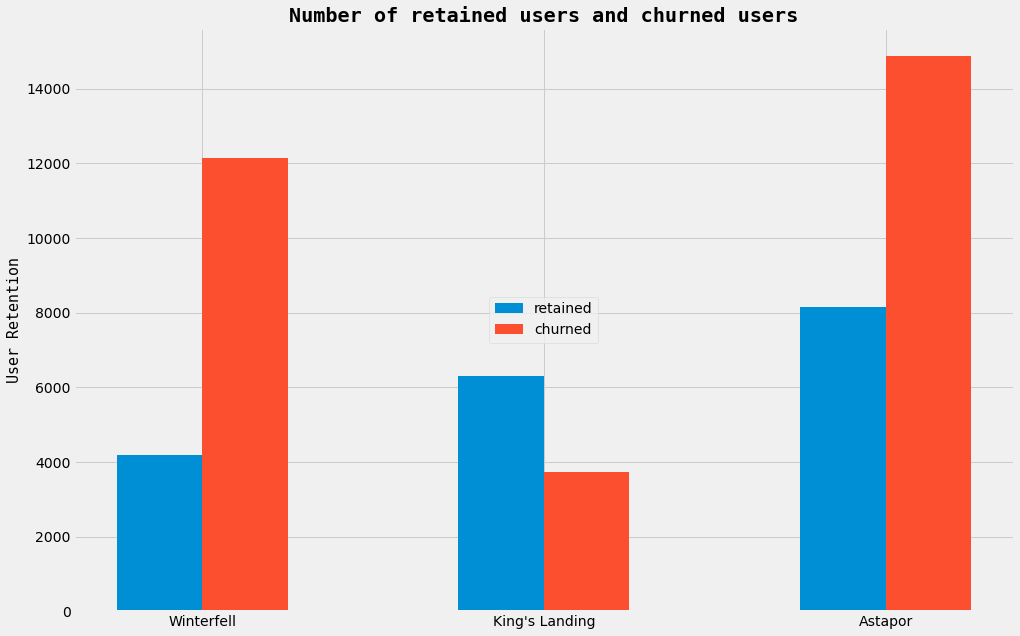

In [26]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize=(15,10))

# set height of bar
retained = data[data['user_retention'] == 1]['count']
churned = data[data['user_retention'] == 0]['count']

# set position of bar on X axis
br1 = np.arange(len(retained))
br2 = [x + barWidth for x in br1]

# Make the plot
plt.bar(br1, retained, width=barWidth, label = 'retained')
plt.bar(br2, churned, width=barWidth, label = 'churned')

# Adding Xticks
plt.ylabel('User Retention',family = 'monospace', fontsize = 15)
plt.xticks([r + barWidth/2 for r in range(len(retained))],
        set(data['city']))
plt.title('Number of retained users and churned users', family = 'monospace', fontweight = 'bold')
plt.legend(loc='center')
plt.show()

In the city of Astapor, the number of user retention is greater than that of user churn.

**What fraction of the observed users were retained?**

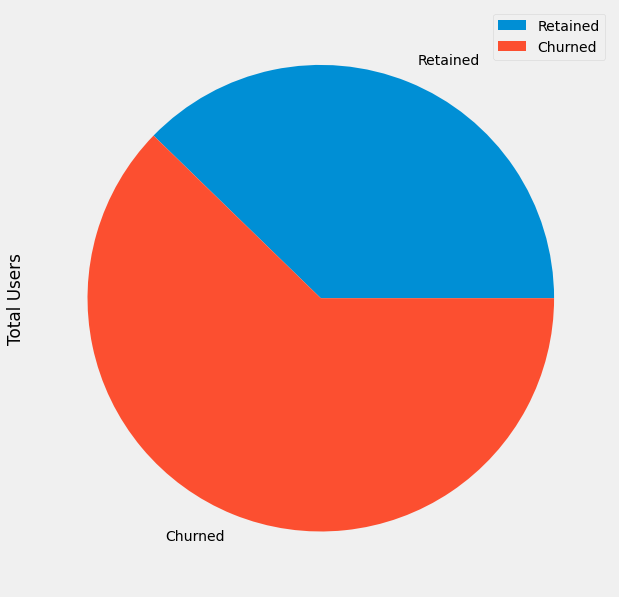

In [27]:
for_pie = pd.DataFrame({'Total Users':[df['user_retention'].sum(),len(df)-df['user_retention'].sum()]},
              index = ['Retained','Churned'])
for_pie.plot.pie(y='Total Users',figsize=(15,10))
plt.show()

There is at least 37.7% of user retention since the last trip the user is either on or after June 1, 2014.

## **Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.**

In [28]:
# Feature Engineering
for c in ['city','phone']: # get dummies
    df = pd.concat([pd.get_dummies(df[c],drop_first = True),df.drop(c,axis=1)],axis=1)
df['signup_days'] = df['signup_date'].dt.day

In [29]:
# Remove features
features = ['trips_in_first_30_days',
            'signup_date',
            'last_trip_date',
            'ultimate_black_user']

# Drop these leakages
df = df.drop(features,axis=1)

In [30]:
# X is a matrix of inputs for prediction and y is target variable
X, y = df.drop('user_retention',axis=1), df.user_retention

In [31]:
# Split training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                            y, test_size = 0.4, random_state = 112)
X_val, X_test, y_val, y_test = train_test_split(X_test, 
                                            y_test, test_size = 0.5, random_state = 112)

In [32]:
# lgbm eval acts as objective function for surrogate and acquistion functions
def lgbm_eval(max_depth,learning_rate,n_estimators, reg_lambda, reg_alpha):
    lgbm_model = LGBMClassifier(max_depth = int(round(max_depth,0)),
                                reg_lambda = reg_lambda,
                                reg_alpha = reg_alpha,
                                learning_rate = learning_rate, 
                                n_estimators = int(round(n_estimators,0)))
     
    lgbm_model.fit(X_train, y_train)
    return matthews_corrcoef(y_val, lgbm_model.predict(X_val))

In [33]:
# Create the Bayesian optimization function to capture best hyperparameters
lgbmBO = BayesianOptimization(lgbm_eval, {'max_depth':(2,10),
                                          'learning_rate':(0.01,0.5),
                                          'n_estimators':(5,20),
                                          'reg_lambda':(0,10),
                                          'reg_alpha':(0,10)})

# Probablistic model constructs through five iterative steps and then initialize search after five steps
lgbmBO.maximize(n_iter=20, init_points=5)

|   iter    |  target   | learni... | max_depth | n_esti... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------
|  1        |  0.4852   |  0.4038   |  5.329    |  6.374    |  2.992    |  3.573    |
|  2        |  0.4855   |  0.2231   |  5.93     |  15.48    |  4.883    |  6.177    |
|  3        |  0.493    |  0.4969   |  9.638    |  6.249    |  3.402    |  1.272    |
|  4        |  0.4856   |  0.1945   |  7.641    |  14.79    |  8.242    |  3.046    |
|  5        |  0.4944   |  0.2886   |  5.539    |  19.72    |  3.899    |  4.423    |
|  6        |  0.4051   |  0.06765  |  3.152    |  9.372    |  4.269    |  6.464    |
|  7        |  0.4835   |  0.364    |  2.894    |  10.03    |  3.159    |  5.551    |
|  8        |  0.4813   |  0.1745   |  7.302    |  9.373    |  9.911    |  8.321    |
|  9        |  0.4819   |  0.4619   |  2.05     |  9.014    |  7.103    |  4.194    |
|  10       |  0.462    |  0.1048   |  2.961    |  10.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


|  20       |  0.0      |  0.01     |  5.696    |  18.75    |  5.074    |  3.447    |
|  21       |  0.4901   |  0.1747   |  7.235    |  19.56    |  3.409    |  3.337    |
|  22       |  0.5027   |  0.5      |  7.353    |  19.08    |  4.001    |  4.454    |
|  23       |  0.4978   |  0.5      |  6.312    |  18.88    |  3.19     |  4.954    |
|  24       |  0.5068   |  0.5      |  7.589    |  17.83    |  4.363    |  4.894    |
|  25       |  0.5033   |  0.5      |  8.15     |  18.55    |  5.037    |  4.157    |


Each warning states that MCC score is undefined due to zero in denominator, which should not be concerned.

In [34]:
# Best hyperparameters
print(lgbmBO.max['params'])

{'learning_rate': 0.5, 'max_depth': 7.588997561618704, 'n_estimators': 17.83112427253437, 'reg_alpha': 4.3632372323226765, 'reg_lambda': 4.894415878126762}


In [35]:
# Store best model in this object
best_lgbm = LGBMClassifier(max_depth = int(round(lgbmBO.max['params']['max_depth'],0)),
                                reg_lambda = lgbmBO.max['params']['reg_lambda'],
                                reg_alpha = lgbmBO.max['params']['reg_alpha'],
                                learning_rate = lgbmBO.max['params']['learning_rate'], 
                                n_estimators = int(round(lgbmBO.max['params']['n_estimators'],0)))
# Fit this model
best_lgbm.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.5, max_depth=8, n_estimators=18,
               reg_alpha=4.3632372323226765, reg_lambda=4.894415878126762)

In [36]:
# Create a function for set of metric scores, for confusion matrix
def create_score(X, y):
    matthew = matthews_corrcoef(y, best_lgbm.predict(X))
    cf_matrix = confusion_matrix(y, best_lgbm.predict(X))
    roc_auc = roc_auc_score(y, best_lgbm.predict(X))
    rmse = np.sqrt(sum((y - best_lgbm.predict(X))**2)/len(y))
    return "\n\nMCC score={:0.3f}\nROC AUC score ={:0.3f}\nRMSE={:0.3f}".format(
        matthew,roc_auc,rmse)

In [37]:
# Collect scores for each set
stats_text = []
stats_text.append(create_score(X_train, y_train))
stats_text.append(create_score(X_val, y_val))
stats_text.append(create_score(X_test, y_test))

# Collect matrices for each set
cf_matrices = []
cf_matrices.append(confusion_matrix(y_train, best_lgbm.predict(X_train)))
cf_matrices.append(confusion_matrix(y_val, best_lgbm.predict(X_val)))
cf_matrices.append(confusion_matrix(y_test, best_lgbm.predict(X_test)))

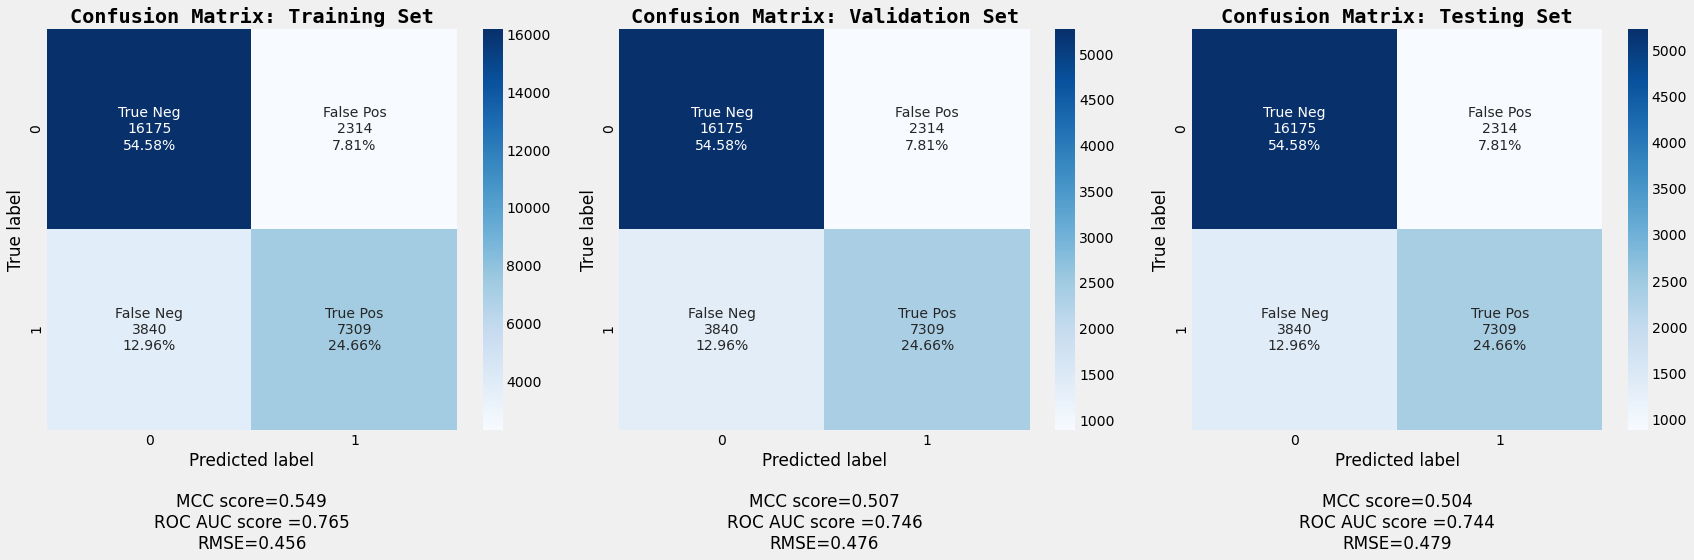

In [38]:
# Build plots
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrices[0].flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrices[0].flatten()/np.sum(cf_matrices[0])]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
titles = ['Confusion Matrix: Training Set','Confusion Matrix: Validation Set',
          'Confusion Matrix: Testing Set']

fig, ax = plt.subplots(1,3, figsize=(24,8))
for i in range(3):
    sns.heatmap(cf_matrices[i], annot=labels, fmt='', cmap='Blues',ax = ax[i])
    ax[i].set_xlabel('Predicted label'+stats_text[i])
    ax[i].set_ylabel('True label')
    ax[i].set_title(titles[i], family='monospace',fontweight='bold')
plt.tight_layout()
plt.show()

The approach to answering this question is to go through feature engineering, imbalance data management, and model selection. The feature engineering is to eliminate certain features that consider to be leaked and get dummies for `city` and `phone`. The data leakage refer to certain features that will not be existed when model is deployed and that need to be eliminated. Otherwise, the prediction score is more likely to overestimate. The thought process to select the right model is based on how the model can deal with NaN and without requiring standard scaler. The light gradient boosting classifier model is more appropriate since it can treat NaN as a predictor value, rather than ignoring it. There are several alternative models that can be in use to deal with NaN. The random forest model is one of these examples. There are also several methods to deal with NaN by either mean imputation or interpolation using KNN algorithm.

As mentioned earlier, this approach needs to deal wtih imbalance data problem that could overestimate prediction score. The Matthews Correlation Coefficient (MCC) is suitable for this imbalance data problem. Another way to deal this problem is to use a approach called Synthetic Minority Oversampling Technique (SMOTE) or F1 score. However, MCC is more preferable over F1 score because the F1 score does not account for true negative values. The next step is to optimize the prediction model using Bayesian Search Theory where the MCC score for validation set is in use as an objective function. As indicated by confusion matrix and a set of metrics in testing set, this model is not overfitted. Even though MCC score shows that strong positive relationship between predicted and actual values and ROC AUC score gives a good indicator, the RMSE shows that the model is, unfortunately, not well-calibrated. But in social science sense, this model is quite high accurate. But the concern is that this analysis does not account for time. The demand behavior can change over time. 

## **Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).**

In [39]:
df.head()

iPhone  King's Landing  Winterfell  avg_rating_of_driver  avg_surge  \
0       1               1           0                   4.7       1.10   
1       0               0           0                   5.0       1.00   
2       1               0           0                   4.3       1.00   
3       1               1           0                   4.6       1.14   
4       0               0           1                   4.4       1.19   

   surge_pct  weekday_pct  avg_dist  avg_rating_by_driver  user_retention  \
0       15.4         46.2      3.67                   5.0               1   
1        0.0         50.0      8.26                   5.0               0   
2        0.0        100.0      0.77                   5.0               0   
3       20.0         80.0      2.36                   4.9               1   
4       11.8         82.4      3.13                   4.9               0   

   signup_days  
0           25  
1           29  
2            6  
3           10  
4           27

List of Counterfactuals:
- What if average ratings by drivers are all 1?
- What if weekday percentage is less than 50%?
- What if signup_day is 1.0

In [44]:
# Create list of counterfactuals
counterfactual1 = X.copy()
counterfactual2 = X.copy()
counterfactual3 = X.copy()

counterfactual1['avg_rating_by_driver'] = 1.0
counterfactual2['weekday_pct'] = counterfactual3['weekday_pct'].apply(lambda x: 50.0 if x >= 50.0 else x)
counterfactual3['signup_days'] = 1.0 

answers = pd.DataFrame({'Actual':[best_lgbm.predict(X).mean(),
           best_lgbm.predict(X).mean(),
           best_lgbm.predict(X).mean()], 
 'Counterfactual':[best_lgbm.predict(counterfactual1).mean(),
                   best_lgbm.predict(counterfactual2).mean(),
                   best_lgbm.predict(counterfactual3).mean()],
 'category':['What if avg_rating_by_driver = 1.0', 
             'What if weekday_pct is < 50%',
             'What if signup_day = 1.0']})

In [45]:
answers

Actual  Counterfactual                            category
0  0.326835        0.151686  What if avg_rating_by_driver = 1.0
1  0.326835        0.333273        What if weekday_pct is < 50%
2  0.326835        0.365339            What if signup_day = 1.0

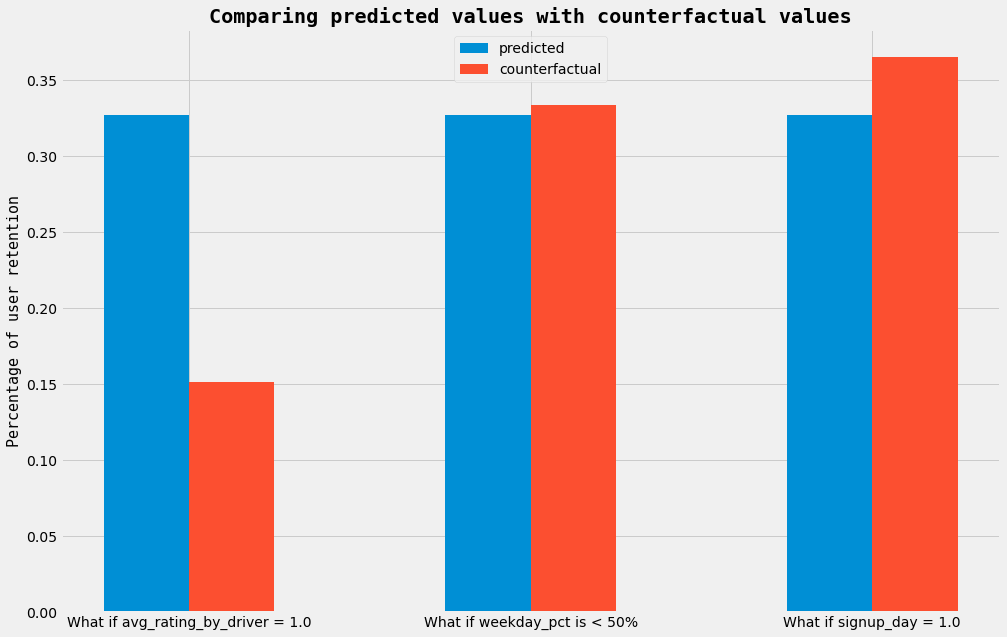

In [50]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize=(15,10))

# set height of bar
predicted = answers['Actual']
counterfactual = answers['Counterfactual']

# set position of bar on X axis
br1 = np.arange(len(retained))
br2 = [x + barWidth for x in br1]

# Make the plot
plt.bar(br1, predicted, width=barWidth, label = 'predicted')
plt.bar(br2, counterfactual, width=barWidth, label = 'counterfactual')

# Adding Xticks
plt.ylabel('Percentage of user retention',family = 'monospace', fontsize = 15)
plt.xticks([r + barWidth/2 for r in range(len(retained))],
        answers['category'])
plt.title('Comparing predicted values with counterfactual values', family = 'monospace', fontweight = 'bold')
plt.legend(loc='upper center')
plt.show()

The prediction model can be in use to address the *counterfactual* but it should not be in use to establish *causal* relationship. There is a difference between causal relationship and counterfactual that need to be mentioned. The causality is interpreted as an evidence that X is the reason for y. But manipulating X to reveal y behavior is not sufficient to determine the nature of causality. This approach may either overestimate or underestimate the value of y. The causal analysis relies on observable data. But the counterfactual is in use to determine unobservable data by asking a "what would have happened if..." question. As indicated by the plot, the percentage of user retention would reduce if all average ratings by drivers are 1. The percentage of user retention would increase if every consumer signs up on the first day of month.   